# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Plot Time Series Graph
def plot_time_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)  

# To generate trend
def trend(time, slope=0):
  return time * slope

# To generate Seasonal Pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
# To generate seasonality data
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# To generate noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

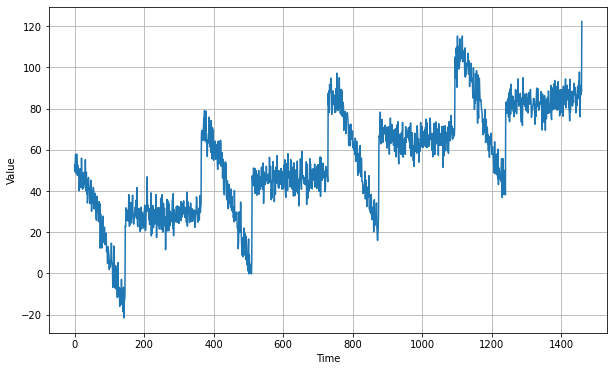

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Forecasting with Machine Learning

In [ ]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset

In [5]:
split_time = 1000

time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

In [31]:
len(x_train), len(x_valid)

(1000, 461)

## 1- Linear Model

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30

train_set = window_dataset(x_train, window_size=WINDOW_SIZE)
valid_set = window_dataset(x_valid, window_size=WINDOW_SIZE)

In [9]:
print(train_set)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float64, tf.float64)>


In [10]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[WINDOW_SIZE])
])

linear_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics = ['mae']
)

linear_history = linear_model.fit(train_set,
                                  epochs=100,
                                  validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - l

In [18]:
tf.keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30

train_set = window_dataset(x_train, window_size=WINDOW_SIZE)

In [19]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[WINDOW_SIZE])
])

linear_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics = ['mae']
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch/30)
)

linear_history = linear_model.fit(train_set,
                                  epochs=100,
                                  callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [==============================]

In [20]:
# linear_history.history

(1e-06, 0.001, 0.0, 20.0)

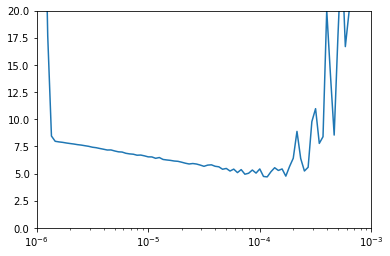

In [21]:
plt.semilogx(linear_history.history['lr'], linear_history.history['loss'])
plt.axis([1e-6, 1e-3, 0, 20])

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30

train_set = window_dataset(x_train, window_size=WINDOW_SIZE)
valid_set = window_dataset(x_valid, window_size=WINDOW_SIZE)

In [23]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[WINDOW_SIZE])
])

linear_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics = ['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
linear_history = linear_model.fit(train_set,
                                  epochs=100,
                                  validation_data=valid_set,
                                  callbacks=[early_stopping])

Epoch 1/100
31/31 [==============================] - 1s 8ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - lo

In [27]:
def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

In [28]:
linear_forecast = model_forecast(linear_model, series[split_time - WINDOW_SIZE: -1], WINDOW_SIZE)[:,0]
linear_forecast.shape

(461,)

In [30]:
linear_mae = tf.keras.metrics.mean_absolute_error(x_valid, linear_forecast)
linear_mae

<tf.Tensor: shape=(), dtype=float32, numpy=6.097048>

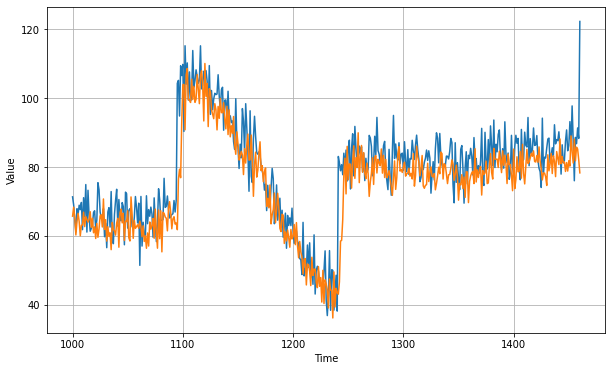

In [29]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, linear_forecast)

## 2- Dense Model Forecasting

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = window_dataset(x_train, WINDOW_SIZE)

dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

dense_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
    metrics = ['mae']
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch/20)
)

dense_history = dense_model.fit(train_set,
                                epochs=100,
                                callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 43.8270 - mae: 44.3262
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 41.5210 - mae: 42.0202
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.6253 - mae: 39.1248
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 35.3203 - mae: 35.8201
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 31.5905 - mae: 32.0903
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 27.4033 - mae: 27.9022
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.7830 - mae: 23.2804
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 17.7632 - mae: 18.2594
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 12.6771 - mae: 13.1682
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 8.5974 - mae: 9.0856
Epoch 11/100
31/31 [=====================

(1e-07, 0.005, 0.0, 30.0)

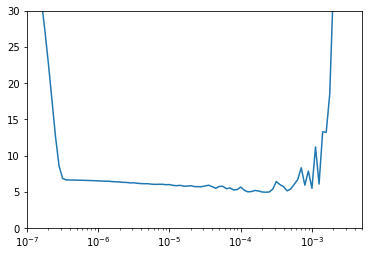

In [37]:
plt.semilogx(dense_history.history['lr'], dense_history.history['loss'])
plt.axis([1e-7, 5e-3, 0, 30])

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

WINDOW_SIZE = 30
train_set = window_dataset(x_train, WINDOW_SIZE)
valid_set = window_dataset(x_valid, WINDOW_SIZE)

dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

dense_model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics = ['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

dense_history = dense_model.fit(train_set,
                                epochs=100,
                                validation_data=valid_set,
                                callbacks=[early_stopping])

Epoch 1/100
31/31 [==============================] - 1s 8ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 6.9028 

In [42]:
dense_forecast = model_forecast(dense_model,
                                series[split_time - WINDOW_SIZE:-1],
                                WINDOW_SIZE)[:,0]

In [43]:
len(dense_forecast)

461

In [45]:
dense_mae = tf.keras.metrics.mean_absolute_error(x_valid, dense_forecast)
dense_mae

<tf.Tensor: shape=(), dtype=float32, numpy=5.23226>

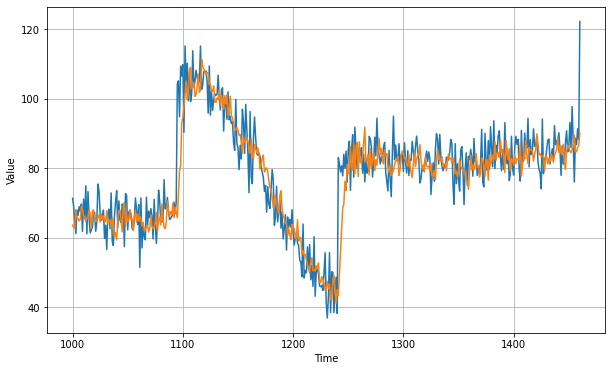

In [44]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, dense_forecast)